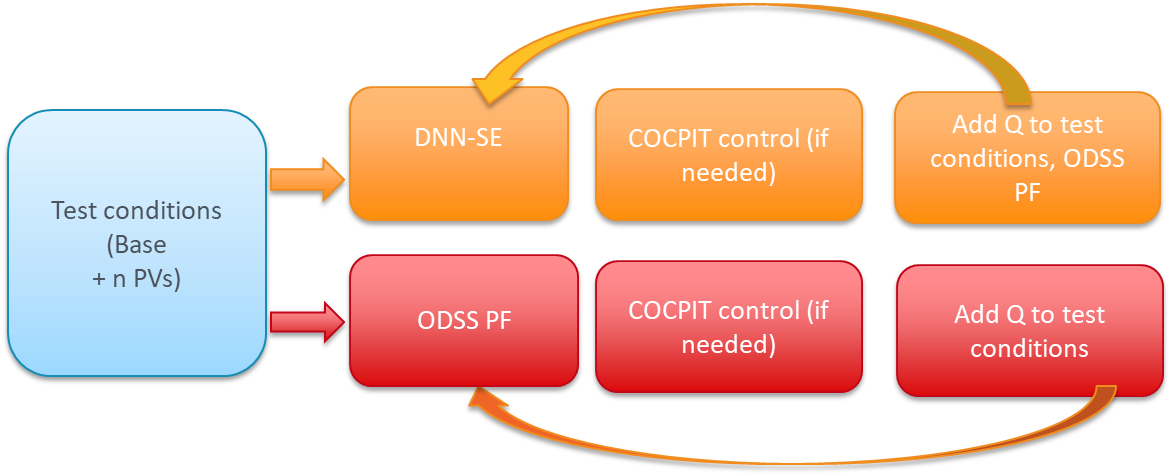

# J-1 Feeder Details
* Num. of buses: **3434**
* Num. of nodes: **4245** (primary and secondary)
* Num. of loads: **1384** (all on secndary side)
* Num. of lines: **2624**
* Num. of initial PVs: **13** (9 single phase, 4 three-phase >> 21 PVs)
* Num. of added PVs: **459** (all single phase)
* Num of all PVs: **472**

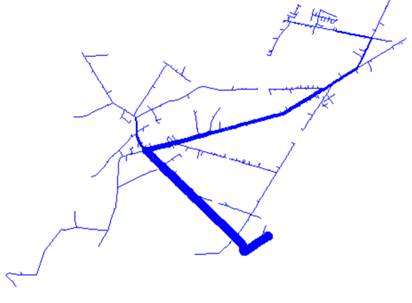

* Make sure to comment "Solve" in OpenDSS file, and clear its history before running this

## Import Required Packages

In [1]:
import dss # required to connect python to OpenDSS
import pandas as pd
import numpy as np
import random
from scipy.io import loadmat
import math
import time
from pyomo.environ import *
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings

np.random.seed(42) # Set a global random seed for reproducibility

## Import OpenDSS interfaces

In [2]:
DSSObj = dss.DSS
DSSText = DSSObj.Text
DSSCircuit = DSSObj.ActiveCircuit
DSSBus = DSSCircuit.ActiveBus
DSSLines = DSSCircuit.Lines
DSSLoads = DSSCircuit.Loads
DSSGenerator = DSSCircuit.Generators
DSSCktElement = DSSCircuit.ActiveCktElement
DSSPVSystem = DSSCircuit.PVSystems
DSSSolution = DSSCircuit.Solution

## Compile the Circuit

In [3]:
# dss_file = "dss files/Master_withPV.dss" # GitHub
dss_file = r"C:\Users\smoshta1\ASU Dropbox\Shiva Moshtagh\Pecan Street Data_Mapping\Python Code Share\Shiva_Practice_temp\Combined Code\GitHub\dss files/Master_withPV.dss"

DSSText.Command=(f"compile [{dss_file}]")

all_bus_name= DSSCircuit.AllBusNames
all_node_name= DSSCircuit.AllNodeNames
all_load_name= DSSLoads.AllNames
all_line_name = DSSLines.AllNames
all_PV_name = DSSPVSystem.AllNames
print(f'Num. of buses: {len(all_bus_name)} \n'
      f'Num. of nodes: {len(all_node_name)} \n'
      f'Num. of loads: {len(all_load_name)} \n'
      f'Num of Lines: {len(all_line_name)} \n'
      f'Num of PVs: {len(all_PV_name)}')

Num. of buses: 3434 
Num. of nodes: 4245 
Num. of loads: 1385 
Num of Lines: 2625 
Num of PVs: 472


## Solve the circuit for 1 scenario

In [4]:
DSSText.Command=("clear")
DSSText.Command=(f"compile [{dss_file}]")
DSSText.Command = 'Solve'

if DSSSolution.Converged:
    print('Solved!')

All_voltages= DSSCircuit.AllBusVolts #Complex array (real+imaginary) of all node voltages from most recent solution - CONSISTENT with all_node_name

#Convert to polar form
AllVolReal=[]
AllVolImg=[]
for i in range(All_voltages.shape[0]):
    remainder= i%2
    if remainder==0:
        AllVolReal.append(All_voltages[i])
    else:
        AllVolImg.append(All_voltages[i])

AllVolMag=[(real**2+img**2)**0.5 for real,img in zip(AllVolReal,AllVolImg)]

# Finding BaseKV for each node
Node_BasekV = {}

# Iterate through each bus by name
for bus in all_bus_name:
    
    # Set the active bus to the current bus in the loop
    DSSCircuit.SetActiveBus(bus)
    active_bus = DSSCircuit.ActiveBus
    
    # Iterate through each node at the bus
    for i in range(active_bus.NumNodes):
        nodeNumber = active_bus.Nodes[i]
        
        # The base kV for a node in a three-phase bus is the nominal voltage (kVBase) divided by sqrt(3)
        # There are 2 base KVs (apart from source bus whose base KV is 69 KV):
        # [12.47, 0.416] which all have been divided by sqrt(3) by default (in DSS files they're all in original format, but here we get them already divided by sqrt(3))
        basekV = active_bus.kVBase # Convert line-to-line voltage to phase voltage
        node_name = f"{bus}.{nodeNumber}"
        
        # Store all base kVs
        Node_BasekV[node_name] = basekV

VoltageBase = list(Node_BasekV.values())
        
# Convert to per unit
AllVolMag_pu=[(AbsVal*1e-3)/BaseVol for AbsVal,BaseVol in zip(AllVolMag,VoltageBase)]
# AllVolMag_pu

Solved!


## Define limits used in optimization

In [5]:
Qmax = 4.8
Qmax_0 = 11
# Margin_1 and Margin_2 refer to targets for Optimization algorithm
# Margin_1 is for first iteration, Margin_2 is for second iteration onwards
Margin_1 = 1.048
Margin_2 = 1.047 #1.048
# Following limits are used for each iteration to determine whether the ODSS (or DNN-SE) targets are within desired range or not. 
# If not, next iteration of Optimization algorithm is performed. They get more relaxed with R2 onwards
R0_hi_lim = 1.049
R1_hi_lim = 1.0483
R1_lo_lim = 1.0477
R2_hi_lim = 1.048
R2_lo_lim = 1.0465
Vminpu_lim = 0.955
Margin_l1 = 0.953
R0_lim_l1 = 0.951
R1_lim_l1_h = 0.954
R1_lim_l1_l = 0.952
R2_lim_l1_h = 0.9545
R2_lim_l1_l = 0.9515
Qmax_var=4.8

## Function for counting voltage violations 

In [6]:
# Measure the violations by phase, secondary and PV locations
# Assumes that at a time only OV or UV violations are present
def viol_count(l_node, Vmag_nodes, allnodenames, Added):
    thresh = 1.05
    thresh_l = 0.95
    Under_set = []
    Exceed_set =[]
    count_nh = 0
    count_n_a=0
    count_n_b=0
    count_n_c=0
    count_nl = 0
    count_sec=0
    count_pvviol=0
    for i in range(l_node):
        k = allnodenames[i][-1]
        x = allnodenames[i][0]
        if Vmag_nodes[i] > thresh:
            count_nh += 1
            if x=='x':
                count_sec +=1
            if k=='1':
                count_n_a += 1
            if k=='2':
                count_n_b += 1
            if k=='3':
                count_n_c += 1
            Exceed_set.append([allnodenames[i],Vmag_nodes[i]])
            if allnodenames[i] in Added:
                count_pvviol += 1
        if Vmag_nodes[i] < thresh_l:
            count_nl += 1
            if x=='x':
                count_sec +=1
            if k=='1':
                count_n_a += 1
            if k=='2':
                count_n_b += 1
            if k=='3':
                count_n_c += 1
            if allnodenames[i] in Added:
                count_pvviol += 1
            Under_set.append([allnodenames[i],Vmag_nodes[i]])
    Vmaxpu_n= max(Vmag_nodes)
    Vminpu_n = min(Vmag_nodes)

    return(Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl)
# Vmaxpu_n & Vminpu_n are max and min voltage values in pu
# count_nh and count_nl are number of OV and UV violations (one of them would be typically zero)
# count_n_a, count_n_b and count_n_c are number of violations by phase (OV or UV) 
# count_sec and count_pvviol are number of violations in secondary and at PV locations, respectively

## Function for counting Q values by phase

In [7]:
# Q_opt is the vector with Q values, n is number of PVs and A is the set of PV location node-names
def Q_count(Q_opt,n, A):
# Initialize Q values
    Q_a = 0
    Q_b = 0
    Q_c = 0
    Q_3p = 0
# Initialize total PV count by each phase (doesn't change)
    PV_count_a = 0
    PV_count_b = 0
    PV_count_c = 0
 # Initialize participating PV count by each phase
    Q_count_a = 0
    Q_count_b = 0
    Q_count_c = 0
    Q_count_3p = 0

    for i in range(n):
        Q_i = Q_opt[i]
        # Phase C
        if '.3' in A[i]:
            Q_c = Q_c + Q_i
            PV_count_c += 1
            if Q_i != 0:
                Q_count_c += 1
        # Phase B
        elif '.2' in A[i]:
            Q_b = Q_b + Q_i
            PV_count_b += 1
            if Q_i != 0:
                Q_count_b += 1
        # Phase A
        elif '.1' in A[i]:
            Q_a = Q_a + Q_i
            PV_count_a += 1
            if Q_i != 0:
                Q_count_a += 1
        # 3-Phase
        else:
            Q_3p = Q_3p + Q_i
            if Q_i != 0:
                Q_count_3p += 1
    # Total
    Q_tot = Q_a + Q_b + Q_c + Q_3p
    return(Q_tot, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p)

## Function for generating Sensitivity Matrix

In [8]:
# Generation of (reduced) sensitivity matrix for the given conditions
# red_nodes = list of reduced nodes including all customer nodes and regulator nodes (should be 1412)
# n = Number of total PVs (including existing PVs)
# i_array = Array of 1:l_node
# flag1 = flag if OV (-1) or UV (1) (can be eliminated as we are only dealing with OV)
def sensit_cal(l_node, l_red, red_nodes, n, i_array, flag1, all_PV_name):
    Voldpu_1 = list(range(0, l_node))
    # Loop through each PV by introducing 1 kVAR perturbation and measuring delta-V
    for i in range(n):
        DSSText.Command = "set maxIter = 100"
        DSSText.Command = "set maxcontroliter = 1000"
        DSSSolution.Solve()
        # Initial voltages without perturbation
        BusVpu1_1 = DSSCircuit.AllBusVmagPu
        # Apply perturbation of -1 kVAr (absorption) if OV and +1 kVAr (injection) if UV
        if flag1==-1:
            DSSText.Command = 'Edit Generator.QVTest'+str(i_array[i])+ ' kVAR =-1' 

        elif flag1==1:
            DSSText.Command = 'Edit Generator.QVTest'+str(i_array[i])+ ' kVAR =1'

        DSSText.Command = "set maxIter = 100"
        DSSText.Command = "set maxcontroliter = 1000"
        DSSSolution.Solve()
        allnodenames=DSSCircuit.AllNodeNames
        # Voltages after perturbation
        BusVpu2_1 = DSSCircuit.AllBusVmagPu
        #Capture deltaV
        deltaVpu_1 = (BusVpu2_1-BusVpu1_1)
        # Stack to the existing matrix
        Vnewpu_1 = np.vstack((Voldpu_1,deltaVpu_1)) #save the delta bus voltages to a matrix
        Voldpu_1 = Vnewpu_1
        # Reset perturbation
        DSSText.Command = 'Edit Generator.QVTest'+str(i_array[i])+ ' kVAR =0'
    # Remove top row, create dataframe
    Vnew2_1 = np.delete(Vnewpu_1, (0), axis=0)
    df_Vnew2= pd.DataFrame(Vnew2_1, columns=allnodenames) 
    Sens_red_temp = np.zeros((n,0))
    # Trim the matrix to include only reduced nodes
    for column in df_Vnew2.columns:
        if column in red_nodes:
            col_temp = df_Vnew2[column].to_numpy().T
            Sens_red_temp = np.column_stack((Sens_red_temp,col_temp))
    return(Sens_red_temp)
# Return reduced sensitivity matrix

## Optimization function for OV conditions

In [9]:
# c_new is the set of existing Q values
# Sensit_use is the sensitivity matrix
# PUvalue is the set of delta-Vs for reduced nodes (Actual voltages - target)
# Qmax_var is the set of maximum values for Q
def optim(c_new, Sensit_use, PUvalue, Qmax_var ):
    # a_new is the sensitivity matrix 
    a_newT = Sensit_use.to_numpy()
    a_new = a_newT.T
    A_new = np.shape(a_new)[1]
    time1 =time.time()
    # b_new is the RHS of the inequality (Q.a_new should be larger than required change)
    b_new = PUvalue.T
    # Define the model and run it in glpk
    model = ConcreteModel()
    model.IDX = range(A_new)
    # set bounds for Qmax, negative to zero, because this function is for OV conditions - meaning Q absorption (-ve value) is required.
    def _bounds_rule(m,i):
        return ( -Qmax_var[i],0)
    # Define model and objective as per the optimization equations
    model.x = Var( range(A_new), within = Reals, bounds = _bounds_rule )
    # Maximization objective is actually leading to minimum Q, due to negative polarity
    model.value = Objective(
    expr = sum( model.x[i] for i in range(A_new)),
    sense = maximize )
    time2 =time.time()
    model.limits = ConstraintList()
# Add constraint for each node that (b_new = existing voltage - target) should be lower than sum of all sensitivity matrix * delta-Q values for each node
    for i in range(len(b_new)):
        model.limits.add((sum(a_new[i][j]*(model.x[j]-c_new[j]) for j in range(A_new)) >= b_new[i]))
    solvername = 'glpk'
    solverpath_exe = r"C:\Users\smoshta1\ASU Dropbox\Shiva Moshtagh\Pecan Street Data_Mapping\Python Code Share\Shiva_Practice_temp\Combined Code\GitHub\optimization files\w64\glpsol.exe"
#     solverpath_exe = "optimization files\w64\glpsol.exe" #GitHub
    
    opt = SolverFactory(solvername, executable = solverpath_exe)

    time3 =time.time()

    result_obj = opt.solve(model, tee=False)
    time4 =time.time()

    return(model, result_obj)
# Return the Q values as model and result_obj (pass or fail)

## Optimization function with relaxed Q constraint 

In [10]:
# Used only if the code doesn't converge with normal optimization
# c_new = values for Q for all PVs (zero for first rev)
# Sensit_use = Sensitivity MAtrix (derived from Sensitivity function - but some processing as in the code)
# PUvalue = delta-V(actual - limit) for each of the redcued matrix nodes (1412)
# Qmax_var = Individual PV max Q values (4.8 default)
def optim2(c_new, Sensit_use, PUvalue, Qmax_var ):
    
    # a_new is the sensitivity matrix 
    a_newT = Sensit_use.to_numpy()
    a_new = a_newT.T
    A_new = np.shape(a_new)[1]
    # b_new is the RHS of the inequality (Q.a_new should be larger than required change)
    b_new = PUvalue.T
    # Define the model and run it in glpk
    # Note: Update to a general (currently, assumes zero starting Q)
    model = ConcreteModel()
    model.IDX = range(A_new)
    def _bounds_rule2(m, i):
        return ( -2*Qmax_var[i],0)
    model.x = Var( range(A_new), within = Reals, bounds = _bounds_rule2 )
    
    model.value = Objective(
    expr = sum( model.x[i] for i in range(A_new)), sense = maximize)
    model.limits = ConstraintList()

    for i in range(len(b_new)):
        model.limits.add((sum(a_new[i][j]*(model.x[j]-c_new[j]) for j in range(A_new)) >= b_new[i]))

    opt = SolverFactory('glpk')
    result_obj = opt.solve(model, tee=False)

    return(model, result_obj)

## Assign maximum  Q values for each PV based on Pmpp

In [11]:
# Assigns the Pmax (Pmpp) and Qmax values
# Qmax is based on 0.9 PF or Smax = 1.1*Pmpp
PVValue0 = []
iPV = DSSPVSystem.First
while iPV>0:
    PVValue0.append(DSSPVSystem.Irradiance * DSSPVSystem.Pmpp)
    iPV = DSSPVSystem.Next
PVValues = np.array(PVValue0)
Qmax_var = 0.48*PVValues
nPV = len(PVValue0)
# print(nPV)

l_node = len(all_node_name)
Added = []
Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, AllVolMag_pu, all_node_name, Added)
# print("Base",Vmaxpu_n, Vminpu_n, count_nh, count_nl)

## Identify the Set of Reduced Nodes based on location (Customer or Regulator)

In [12]:
# Full J1 feeder has 4245 nodes
# In order to reduce computation time, we select only the nodes that are regulator nodes or customer nodes for sensitivity matrix and optimization
#  Effectiveness of the algorithm is still verified based on voltage behavior on all nodes
red_node =[]
for i in range(l_node):
# In J1 feeder, all customer nodes include "cust", e.g., x_6018228840_cust1-c.3 - designates first customer on phase 3(c.3) bus 6018228840, the prefix x_ designates secondary node.
        if 'cust' in all_node_name[i]:
            red_node.append(all_node_name[i])
        elif 'reg' in all_node_name[i]:
            red_node.append(all_node_name[i])
red_nodes=np.array(red_node)
l_red = len(red_nodes)
df_node = pd.DataFrame(red_nodes.T, columns = ['Node_Names'])
Sens_red_temp = np.zeros((l_red,0))
# The count of reduced node is 1412 (1/3 of all nodes)
# print(Sens_red_temp.shape, df_node.shape)

## Read file for random PV additions (matches with the list in newPV.dss)

In [13]:
path = r'C:\Users\smoshta1\ASU Dropbox\Shiva Moshtagh\Pecan Street Data_Mapping\Python Code Share\Shiva_Practice_temp\Combined Code\GitHub\data/'
# path = "data/" #GitHub
file1= "usedbusarray_1000plus_revised.xlsx"
toadd1 = pd.read_excel(path + file1, index_col=0, dtype=str)
toadd= toadd1.iloc[:,0].to_numpy(dtype=str)
toadd_use = toadd[:nPV]
A = toadd_use.T

## Functions for creating DNN-SE dataset

In [14]:
def get_voltages(DSSCircuit_AllBusVolts, VoltageBase):
    All_voltages = DSSCircuit_AllBusVolts
    # Convert to polar form
    AllVolReal = [All_voltages[k] for k in range(0, len(All_voltages), 2)]
    AllVolImg = [All_voltages[k] for k in range(1, len(All_voltages), 2)]

    AllVolMag = [np.sqrt(real**2 + img**2) for real, img in zip(AllVolReal, AllVolImg)]
    AllVolMag_pu = [(AbsVal*1e-3)/BaseVol for AbsVal, BaseVol in zip(AllVolMag, VoltageBase)]
    AllVoltAng_deg = [math.atan2(imag, real)*180/np.pi for imag, real in zip(AllVolImg, AllVolReal)]
    
    return AllVolMag_pu, AllVoltAng_deg

# ----------------------------------------------------------------------------------------------------------------

def get_currents(num_lines, DSSLines, DSSCktElement):
    
    Currents_DSS_Lines = np.zeros((num_lines, 12)) 
    iLine = DSSLines.First
    while iLine > 0:
        if len(DSSCktElement.CurrentsMagAng) == 12: 
            Currents_DSS_Lines[iLine-1, :] = DSSCktElement.CurrentsMagAng
        elif len(DSSCktElement.CurrentsMagAng) == 4:
            if DSSLines.Bus1[-1] == '1': 
                Currents_DSS_Lines[iLine-1,0:2] = DSSCktElement.CurrentsMagAng[0:2]
                Currents_DSS_Lines[iLine-1,6:8] = DSSCktElement.CurrentsMagAng[2:4]
            elif DSSLines.Bus1[-1] == '2':
                Currents_DSS_Lines[iLine-1,2:4] = DSSCktElement.CurrentsMagAng[0:2]
                Currents_DSS_Lines[iLine-1,8:10] = DSSCktElement.CurrentsMagAng[2:4]
            else:  #DSSLines.Bus1[-1] == '3':
                Currents_DSS_Lines[iLine-1,4:6] = DSSCktElement.CurrentsMagAng[0:2]
                Currents_DSS_Lines[iLine-1,10:12] = DSSCktElement.CurrentsMagAng[2:4]

        else:      #len(DSSCktElement.CurrentsMagAng) == 8:
            if DSSLines.Bus1[-3:] == "1.2":
                Currents_DSS_Lines[iLine-1,0:4] = DSSCktElement.CurrentsMagAng[0:4]
                Currents_DSS_Lines[iLine-1,6:10] = DSSCktElement.CurrentsMagAng[4:8]
            elif DSSLines.Bus1[-3:] == "1.3":
                Currents_DSS_Lines[iLine-1,0:2] = DSSCktElement.CurrentsMagAng[0:2]
                Currents_DSS_Lines[iLine-1,4:6] = DSSCktElement.CurrentsMagAng[2:4]
                Currents_DSS_Lines[iLine-1,6:8] = DSSCktElement.CurrentsMagAng[4:6]
                Currents_DSS_Lines[iLine-1,10:12] = DSSCktElement.CurrentsMagAng[6:8]
            else:    #DSSLines.Bus1[-2:] == "2.3": 
                Currents_DSS_Lines[iLine-1,2:6] = DSSCktElement.CurrentsMagAng[0:4]
                Currents_DSS_Lines[iLine-1,8:12] = DSSCktElement.CurrentsMagAng[4:8]

        I_line_bus_names[iLine-1,0] = DSSLines.Bus1
        I_line_bus_names[iLine-1,1] = DSSLines.Bus2
        I_line_bus_names[iLine-1,2] = DSSCktElement.DisplayName

        iLine = DSSLines.Next

    return I_line_bus_names, Currents_DSS_Lines

In [15]:
# Read micro-PMU locations
# for 489 PMUs
path = r'C:\Users\smoshta1\ASU Dropbox\Shiva Moshtagh\Pecan Street Data_Mapping\Python Code Share\Shiva_Practice_temp\Combined Code\GitHub\data/'
# path = "data/" # GitHub
Vpmu_indx = pd.read_csv(path + 'Vpmu_data_489.csv')['Index'].tolist()
IMagpmu_indx = pd.read_csv(path + 'IMagpmu_indx_489.csv')['Index'].tolist()
IAngpmu_indx = pd.read_csv(path + 'IAngpmu_indx_489.csv')['Index'].tolist()

# Build a Gaussian error model with 0.05% TVE
#Magnitude: Mu=[0] , Sigma=[0.0005/3]
#Angle : Mu = [0] , Sigma= [0.0286/3]
np.random.seed(42) 
# Convert TVE from percentage to a fraction
tve = 0.05 / 100
def NoisyAng(data, tve):
    # Generate Gaussian noise for angle (0 mean, std = tve/3 in degrees)
    # Convert TVE to degrees for angle noise
    ang_noise = np.random.normal(0, (tve * 180/np.pi)/3, data.shape)
    noisy_ang_data = data + ang_noise
    return noisy_ang_data

def NoisyMag(data, tve):
    # Generate Gaussian noise for magnitude (0 mean, std = tve/3 * mag_data)
    mag_noise = np.random.normal(0, tve/3, data.shape) * data
    noisy_mag_data = data + mag_noise   
    return noisy_mag_data

# ----------------------------------------------------------------------------------------------------------------

def normalize(x):
    x_min = np.amin(x)
    x_max = np.amax(x)
    x_norm = (x-x_min)/(x_max-x_min)
    
    return x_norm,x_min,x_max

# ----------------------------------------------------------------------------------------------------------------

def build_dataset(i,Vpmu_indx, AllVoltMag_pu, AllVoltAng_deg, IMagpmu_indx,IAngpmu_indx, current, x_train, y_train): # i refers to the index of scenario
    '''
    This function extract data (voltage and current phasors) associated with nodes equipped with micro-PMUs
    Output: dataset to test DNN-SE
    ''' 
    # --------------------------------------------- PMU Data: Voltage --------------------------------------------------
    VMag_pmu = np.array([AllVoltMag_pu[indx] for indx in Vpmu_indx])
    VAng_pmu = np.array([AllVoltAng_deg[indx] for indx in Vpmu_indx])
    
    # --------------------------------------------- PMU Data: Current --------------------------------------------------    
    IMag_pmu = np.array([current[i][indx] for indx in IMagpmu_indx])
    IAng_pmu = np.array([current[i][indx] for indx in IAngpmu_indx])   
    
    #------------------------------------------ ADD Noise -----------------------------------------------------
    noisy_VMag = NoisyMag(VMag_pmu.reshape(1,-1), tve)
    noisy_VAng = NoisyAng(VAng_pmu.reshape(1,-1), tve)
    
    noisy_IMag = NoisyMag(IMag_pmu.reshape(1,-1), tve)
    noisy_IAng = NoisyAng(IAng_pmu.reshape(1,-1), tve)
    
    #------------------------------------------- Build Dataset --------------------------------------------------
    # Concatenate Mag & Ang
    # Voltage
    noisyVMagAng = []
    for q in range(noisy_VMag.shape[1]):
        noisyVMagAng.append(noisy_VMag[:,q])
        noisyVMagAng.append(noisy_VAng[:,q])
    noisy_VMagAng = pd.DataFrame(np.column_stack(noisyVMagAng))
    # Current
    noisy_IMagAng  = pd.DataFrame(np.concatenate((noisy_IMag, noisy_IAng), axis=1))
    
    ## Define input data X and output lables Y
    x_test = pd.concat([noisy_VMagAng, noisy_IMagAng], axis=1, ignore_index=True)
    y_test = pd.DataFrame([AllVoltMag_pu + AllVoltAng_deg])
    
    #Convert to numpy
    x_train = x_train.to_numpy()
    y_train = y_train.to_numpy()
    x_test = x_test.to_numpy()
    y_test = y_test.to_numpy()
    
    
    # Normalization
    #Normalizing Data
    main_y_train = y_train
    main_x_train = x_train
    main_y_test = y_test
    main_x_test = x_test
    
    x_normalized_test = np.zeros(x_test.shape)
    y_normalized_test = np.zeros(y_test.shape)  

    for s in range(x_train.shape[1]):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            t1,x_min,x_max = normalize(x_train[:,s])
            x_normalized_test[:,s] = (x_test[:,s]-x_min)/(x_max-x_min)

    for s in range(y_train.shape[1]):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            t2,y_min,y_max = normalize(y_train[:,s])
            y_normalized_test[:,s] = (y_test[:,s]-y_min)/(y_max-y_min)
    
    y_normalized_test[np.isnan(y_normalized_test)] = 0
    x_normalized_test[np.isnan(x_normalized_test)] = 0
#     x_normalized_test[np.isinf(x_normalized_test)] = 0 # some current measurements can be zero leading to inf values in normalized data
    
    return x_normalized_test, y_normalized_test, main_y_train, main_y_test

# ----------------------------------------------------------------------------------------------------------------

def DNN_SE(model, x_test, y_test, main_y_train, main_y_test):
    '''
    trained_model example: 'DNN_J1_ExtraPVs.h5' 
    Output: predicted voltage mag and ang
    '''
    pred = model.predict(x_test)
    
    num_nodes = int(main_y_train.shape[1]/2)
    mag_indx = np.arange(0, num_nodes)
    ang_indx = np.arange(num_nodes, num_nodes*2)

    pred_actual = np.zeros(y_test.shape)

    #Convert predictions back to actual values from normalized values
    for s in range(main_y_train.shape[1]):
        t2,y_min,y_max = normalize(main_y_train[:,s])
        pred_actual[:,s] = (pred[:,s]*(y_max-y_min))+y_min

    pred_mag_actual = pred_actual[:,mag_indx]
    pred_ang_actual = pred_actual[:,ang_indx]
    
    mag_MAE = mean_absolute_error(main_y_test[:,mag_indx], pred_actual[:,mag_indx])

    return pred_mag_actual, pred_ang_actual, mag_MAE

## Read the trained DNN-SE model and data

In [16]:
path = r'C:\Users\smoshta1\ASU Dropbox\Shiva Moshtagh\Pecan Street Data_Mapping\Python Code Share\Shiva_Practice_temp\Combined Code\GitHub\data/'
# path = "data/" #GitHub

x_train = pd.read_parquet(path+'x_train12')
y_train = pd.read_parquet(path+'y_train12')
# Convert string column names back to integers
x_train.columns = [int(col) if col.isdigit() else col for col in x_train.columns]
y_train.columns = [int(col) if col.isdigit() else col for col in y_train.columns]

trained_model = load_model(path + 'DNN_J1_489PMU_05TVE.h5') #Trained model

# Run the integrated DNN-SE and COCPIT for many scenarios

In [17]:
# Choose the number of scenarios (out of 25000 scenarios)
num_samples = 100

# Read P, Q and PV reuired to run power flow
path = r'C:\Users\smoshta1\ASU Dropbox\Shiva Moshtagh\Pecan Street Data_Mapping\Python Code Share\Shiva_Practice_temp\Combined Code\GitHub\data/'
# path = 'data/' #GitHub

scaled_load_data = pd.read_csv(path + 'scaled_load_data.csv').sample(n=num_samples, random_state=123).reset_index(drop=True)
Q_load_data = pd.read_csv(path + 'Q_load_data.csv').sample(n=num_samples, random_state=123).reset_index(drop=True)
scaled_PV_data = pd.read_csv(path + 'scaled_PV_data.csv').sample(n=num_samples, random_state=123).reset_index(drop=True)

In [18]:
all_load_name = all_load_name[1:]
num_lines = len(all_line_name)
I_line_bus_names = np.empty((num_lines,3) , dtype=object) # 3 includes bus1, bus2 and line names of each line
currents = [] 

dss_results = []
dnn_results = []

i_array = np.arange(0,l_node) 

for ix in range(num_samples):
    # Clear the Cache and former memory
    DSSText.Command = "clear"
    DSSText.Command = "clear DSSCircuit"
    DSSText.Command = "clear DSSBus"
    DSSText.Command = "clear DSSLines"
    DSSText.Command = "clear DSSLoads"
    DSSText.Command = "clear DSSCapBank"
    DSSText.Command = "clear DSSGenerator"
    DSSText.Command = "clear DSSCktElement"
    DSSText.Command = "clear DSSSolution"
    DSSCircuit = DSSObj.ActiveCircuit
    DSSBus = DSSCircuit.ActiveBus
    DSSLines = DSSCircuit.Lines
    DSSLoads = DSSCircuit.Loads
    DSSCapBank = DSSCircuit.Capacitors
    DSSGenerator = DSSCircuit.Generators
    DSSCktElement = DSSCircuit.ActiveCktElement
    DSSSolution = DSSCircuit.Solution

    DSSText.Command = f"compile [{dss_file}]"

    Added=[]
    dss_data = [] # to store vmin, vmax, #OV cases and Q_opt in each scenario/sample
    dnn_data = []

    # Assign load values to each load
    for j in range(len(all_load_name)):
        DSSText.Command = f"edit Load.{all_load_name[j]} kW={scaled_load_data.iloc[ix,j]} kvar={Q_load_data.iloc[ix,j]}"

    
    # Add two dummy generators at each PV node
    # First generator (QVTest_p) is used to generate the sensitivity matrix and will have all 0 (kVAR and kW) values for actual circuit run
    # Second generator (QVB_p) is used to inject/absorb the Q values calculated by the optimizer for each PV
    for p in range(len(all_PV_name)):
        k = str(all_PV_name[p])
        Added.append(k.lower())
        DSSText.Command = 'New Generator.QVTest'+str(i_array[p])+ ' bus1='+toadd[p]+ ' Phases= 1 Model=7 kV=  0.24 kW=  0 kVAR= 0 Basefreq = 60' 
        DSSText.Command = f"edit PVSystem.{all_PV_name[p]} Pmpp={scaled_PV_data.iloc[ix,p]}"
        Gen_str1 = "QVB" + str(p)
        Bus_str = A[p]
        DSSText.Command = f"New Generator.{Gen_str1} bus1={Bus_str} Phases= 1 Model=7 kV= 0.24 kW=  0 kVAR=0 Basefreq = 60" 
# Initial power flow solution (UPF or R0) - all Q values are zero. 
    DSSText.Command = 'Solve'
    allnodenames=DSSCircuit.AllNodeNames
    l_node1 = len(allnodenames)
    if DSSSolution.Converged:
        print("")
        print(f'Scenario {ix+1} Solved!')
# Check Initial (R0) voltages from power flow and from  DNN-SE, record the violations and their breakdown for both power flow output and DNN-SE output
        Vmag_nodes0 = DSSCircuit.AllBusVmagPu
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes0, allnodenames, Added)
        Vmax_ind = np.argmax(Vmag_nodes0)
        print(f"Scenario{ix+1} R0 (before DNN-SE): Vmax= {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c}, Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dss_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, np.nan,0])
        # ************************* VOLTAGES **********************************************************
        AllVolMag_pu, AllVoltAng_deg= get_voltages(DSSCircuit.AllBusVolts, VoltageBase)
        # ************************* CURRENTS **********************************************************
        I_line_bus_names, Currents_DSS_Lines = get_currents(num_lines, DSSLines, DSSCktElement)
        currents.append(Currents_DSS_Lines.flatten().tolist())
        # ************************* Build Dataset for DNN-SE and Run DNN-SE ***************************
        x_test, y_test, main_y_train, main_y_test = build_dataset(ix, Vpmu_indx, AllVolMag_pu, AllVoltAng_deg, IMagpmu_indx,IAngpmu_indx, currents, x_train, y_train) # ix refers to the index of scenario
        # pred_mag is the output of DNN-SE
        pred_mag, pred_ang, mag_MAE = DNN_SE(trained_model, x_test, y_test, main_y_train, main_y_test) # pred_mag is an array with size of (1,4245) containing voltage magnitude estimates of all 4245 nodes in J-1 Feeder
        print(f'DNN-SE R0 Magnitude MAE (Before Optimization): {mag_MAE:.5f} p.u.')

        Vmag_nodes = pred_mag.reshape(-1,)
        Vmax_ind = np.argmax(Vmag_nodes)
        Vmag_red = []
        for j in range(l_node):
            if allnodenames[j] in red_nodes:
                Vmag_red.append(Vmag_nodes[j])
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes, all_node_name, Added)
        print(f"Scenario{ix+1} R0 (after DNN-SE): Vmax = {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c}, Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dnn_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, mag_MAE,0])
# Assign flag based on presence of OV (-1) or UV (1) conditions
# With the currently used cases, only OV conditions expected
        if max(Vmag_nodes)<Vminpu_lim:
            flag1 = 1
        else:
            flag1 = -1
# Skip optimization if there are no violations with guardbands for DNN-SE voltages
        if ((Vmaxpu_n <= R0_hi_lim) and (Vminpu_n > R0_lim_l1)):
            print("No optimization needed")
            continue
# Compute the sensitivity matrix for reduced node set for R1
        Vnew2_1 = sensit_cal(l_node1, l_red, red_nodes, nPV, i_array, flag1, all_PV_name)
        df_Vnew2_1 = pd.DataFrame(Vnew2_1)
        df_Vnew2_1.to_csv(f'Sensit_R1_Aug_Shiva.csv')
        Sensit_use = df_Vnew2_1.iloc[:nPV,:]
# Run optimization with the DNN-SE output voltages (for reduced node set), initial Q values are set at zero.
        PUvalue = Vmag_red
        PUvalue_array = np.array(PUvalue)
        Q_opt0 = np.zeros(nPV)
        PUvalue1 = ( np.array(PUvalue) - Margin_1)
        model1, result_obj1 = optim(Q_opt0, Sensit_use, PUvalue1, Qmax_var ) # R1
# Go to next scenario if opimization does not succeed 
        if result_obj1.solver.termination_condition != "optimal":
            print("Optimization failed R1")
            continue
# Assign the optimization output Q values to the PVs (Qopt1)
        Q_opt1 = np.zeros(nPV)
        for m in range(nPV):   
            Q_opt1[m] = value(model1.x[m])
        QtotR1, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p = Q_count(Q_opt1,nPV, A)
        print(QtotR1, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p)
        for i in range(nPV):
            k = Q_opt1[i]
            Gen_str = "QVB" +str(i)
            DSSText.Command = f"Edit Generator.{Gen_str} kVAR={k}"
# Perform power flow with the newly assigned Q values
        DSSText.Command = "set maxIter = 100"
        DSSText.Command = "set maxcontroliter = 1000"
        DSSText.Command = 'Solve'
# Check first iteration (R1) voltages from power flow and from  DNN-SE, record the violations and their breakdown for both power flow output and DNN-SE output
        Vmag_nodes1 = DSSCircuit.AllBusVmagPu
        Vmax_ind = np.argmax(Vmag_nodes1)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes1, allnodenames, Added)
        
        print(f"Scenario{ix+1} R1 (before DNN-SE): Vmax= {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c}, Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dss_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, np.nan,Q_opt1.sum()])

        # ************************* VOLTAGES **********************************************************
        AllVolMag_pu, AllVoltAng_deg = get_voltages(DSSCircuit.AllBusVolts, VoltageBase)
        # ************************* CURRENTS **********************************************************
        I_line_bus_names, Currents_DSS_Lines = get_currents(num_lines, DSSLines, DSSCktElement)
        currents.append(Currents_DSS_Lines.flatten().tolist())
        # ************************* Build Dataset for DNN-SE and Run DNN-SE ***************************
        x_test, y_test, main_y_train, main_y_test = build_dataset(ix, Vpmu_indx, AllVolMag_pu, AllVoltAng_deg, IMagpmu_indx,IAngpmu_indx, currents, x_train, y_train) # ix refers to the index of scenario
        pred_mag, pred_ang, mag_MAE = DNN_SE(trained_model, x_test, y_test, main_y_train, main_y_test) # pred_mag is an array with size of (1,4242) containing voltage magnitude estimates of all 4242 nodes in J-1 Feeder
        print(f'DNN-SE Magnitude MAE (R1): {mag_MAE:.5f} p.u.')

        Vmag_nodes_post1 = pred_mag.reshape(-1,) # Shiva
        Vmax_ind = np.argmax(Vmag_nodes_post1)

        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes_post1, allnodenames, Added)
        print(f"Scenario{ix+1} R1 (after DNN-SE): Vmax = {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c}, Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dnn_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, mag_MAE,Q_opt1.sum()])
# Skip optimization if there are no violations with guardbands for DNN-SE voltages and if there is no overcorrection on the Vmax
        if ((Vmaxpu_n  <= R1_hi_lim) and (Vmaxpu_n >= R1_lo_lim) and (Vminpu_n > Vminpu_lim)):
            print("R1 target")
            continue
# Compute the sensitivity matrix for reduced node set for R2
        Vnew2_2 = sensit_cal(l_node1, l_red, red_nodes, nPV, i_array, flag1, all_PV_name)
        df_Vnew2_2 = pd.DataFrame(Vnew2_2)
        Sensit_use_2 = df_Vnew2_2.iloc[:nPV,:]
        Vmag_red = []
# Run optimization with the DNN-SE output voltages (for reduced node set), use Q values from prior round.
        for i in range(l_node):
            if allnodenames[i] in red_nodes:
                Vmag_red.append(Vmag_nodes_post1[i])
        PUvalue_post2 = Vmag_red
        PUvalue2 = (np.array(PUvalue_post2) - Margin_2)
        model2, result_obj2 = optim(Q_opt1, Sensit_use_2, PUvalue2, Qmax_var ) # R2
        if result_obj2.solver.termination_condition != "optimal":
            print("Optimization failed R2")
            continue
# Assign the optimization output Q values to the PVs (Qopt2)
        Q_opt2 = np.zeros(nPV)
        for m in range(nPV):   
            Q_opt2[m] = value(model2.x[m])

        QtotR2, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p = Q_count(Q_opt2,nPV, A)
        print(QtotR2, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b,Q_count_c, Q_count_3p)
        for i in range(nPV):
            k = Q_opt2[i]
            Gen_str = "QVB" +str(i)
            DSSText.Command = f"Edit Generator.{Gen_str} kVAR={k}"
# Perform power flow with the newly assigned Q values
        DSSText.Command = "set maxIter = 100"
        DSSText.Command = "set maxcontroliter = 1000"
        DSSText.Command = 'Solve'
# Check R2 voltages from power flow and from  DNN-SE, record the violations and their breakdown for both power flow output and DNN-SE output
        Vmag_nodes2 = DSSCircuit.AllBusVmagPu
        Vmax_ind = np.argmax(Vmag_nodes2)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes2, allnodenames, Added)
        print(f"Scenario{ix+1} R2 (before DNN-SE): Vmax= {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dss_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, np.nan,Q_opt2.sum()])

        # ************************* VOLTAGES **********************************************************
        AllVolMag_pu, AllVoltAng_deg = get_voltages(DSSCircuit.AllBusVolts, VoltageBase)
        # ************************* CURRENTS **********************************************************
        I_line_bus_names, Currents_DSS_Lines = get_currents(num_lines, DSSLines, DSSCktElement)
        currents.append(Currents_DSS_Lines.flatten().tolist())
        # ************************* Build Dataset for DNN-SE and Run DNN-SE ***************************
        x_test, y_test, main_y_train, main_y_test = build_dataset(ix, Vpmu_indx, AllVolMag_pu, AllVoltAng_deg, IMagpmu_indx,IAngpmu_indx, currents, x_train, y_train) # ix refers to the index of scenario
        pred_mag, pred_ang, mag_MAE = DNN_SE(trained_model, x_test, y_test, main_y_train, main_y_test) # pred_mag is an array with size of (1,4242) containing voltage magnitude estimates of all 4242 nodes in J-1 Feeder
        print(f'DNN-SE Magnitude MAE (R2): {mag_MAE:.5f} p.u.')
        Vmag_nodes_post2 = pred_mag.reshape(-1,) # Shiva
        Vmax_ind = np.argmax(Vmag_nodes_post2)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes_post2, allnodenames, Added)

        print(f"Scenario{ix+1} R2 (after DNN-SE): Vmax = {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dnn_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, mag_MAE,Q_opt2.sum()])
# Skip optimization if there are no violations with guardbands for DNN-SE voltages and if there is no overcorrection on the Vmax
        if ((Vmaxpu_n  <= R2_hi_lim) and (Vmaxpu_n >= R2_lo_lim) and (Vminpu_n > Vminpu_lim)):
            dss_results.append(dss_data)
            dnn_results.append(dnn_data)
            print("R2 target")
            continue
# Compute the sensitivity matrix for reduced node set for R3
        Vnew2_3 = sensit_cal(l_node1, l_red, red_nodes, nPV, i_array, flag1, all_PV_name)
        df_Vnew2_3 = pd.DataFrame(Vnew2_3)
        Sensit_use_3 = df_Vnew2_3.iloc[:nPV,:]
        Vmag_red = []

        for i in range(l_node):
            if allnodenames[i] in red_nodes:
                Vmag_red.append(Vmag_nodes_post2[i])

# Run optimization with the DNN-SE output voltages (for reduced node set), use Q values from prior round.
        PUvalue_post3 = Vmag_red
        PUvalue3 = (np.array(PUvalue_post3) - Margin_2)
        model3, result_obj3 = optim(Q_opt2, Sensit_use_3, PUvalue3, Qmax_var ) # R3
        if result_obj3.solver.termination_condition != "optimal":
            print("Optimization failed R3")
            continue
# Assign the optimization output Q values to the PVs (Qopt3)
        Q_opt3 = np.zeros(nPV)
        for m in range(nPV):   
            Q_opt3[m] = value(model3.x[m])
        QtotR3, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p= Q_count(Q_opt3,nPV, A)
        print(QtotR3, Q_a, Q_b, Q_3p, Q_c, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p)
        for i in range(nPV):
            k = Q_opt3[i]
            Gen_str = "QVB" +str(i)
            DSSText.Command = f"Edit Generator.{Gen_str} kVAR={k}"
# Perform power flow with the newly assigned Q values
        DSSText.Command = "set maxIter = 100"
        DSSText.Command = "set maxcontroliter = 1000"
        DSSText.Command = 'Solve'
# Check R3 voltages from power flow and from  DNN-SE, record the violations and their breakdown for both power flow output and DNN-SE output
        Vmag_nodes3 = DSSCircuit.AllBusVmagPu
        Vmax_ind = np.argmax(Vmag_nodes3)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes3, allnodenames, Added)
        print(f"Scenario{ix+1} R3 (before DNN-SE): Vmax= {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dss_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, np.nan,Q_opt3.sum()])

        # ************************* VOLTAGES **********************************************************
        AllVolMag_pu, AllVoltAng_deg = get_voltages(DSSCircuit.AllBusVolts, VoltageBase)
        # ************************* CURRENTS **********************************************************
        I_line_bus_names, Currents_DSS_Lines = get_currents(num_lines, DSSLines, DSSCktElement)
        currents.append(Currents_DSS_Lines.flatten().tolist())
        # ************************* Build Dataset for DNN-SE and Run DNN-SE ***************************
        x_test, y_test, main_y_train, main_y_test = build_dataset(ix, Vpmu_indx, AllVolMag_pu, AllVoltAng_deg, IMagpmu_indx,IAngpmu_indx, currents, x_train, y_train) # ix refers to the index of scenario
        pred_mag, pred_ang, mag_MAE = DNN_SE(trained_model, x_test, y_test, main_y_train, main_y_test) # pred_mag is an array with size of (1,4242) containing voltage magnitude estimates of all 4242 nodes in J-1 Feeder
        print(f'DNN-SE Magnitude MAE (R3): {mag_MAE:.5f} p.u.')

        Vmag_nodes_post3 = pred_mag.reshape(-1,) # Shiva
        Vmax_ind = np.argmax(Vmag_nodes_post3)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes_post3, allnodenames, Added)

        print(f"Scenario{ix+1} R3 (after DNN-SE): Vmax = {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dnn_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, mag_MAE,Q_opt3.sum()])
# Skip optimization if there are no violations with guardbands for DNN-SE voltages and if there is no overcorrection on the Vmax
        if ((Vmaxpu_n  <= R2_hi_lim) and (Vmaxpu_n >= R2_lo_lim) and (Vminpu_n > Vminpu_lim)):
            dss_results.append(dss_data)
            dnn_results.append(dnn_data)
            print("R3 target")
            continue
# Compute the sensitivity matrix for reduced node set for R4            
        Vnew2_4 = sensit_cal(l_node1, l_red, red_nodes, nPV, i_array, flag1, all_PV_name)
        df_Vnew2_4 = pd.DataFrame(Vnew2_4)
        Sensit_use_4 = df_Vnew2_4.iloc[:nPV,:]
        Vmag_red = []

        for i in range(l_node):
            if allnodenames[i] in red_nodes:
                Vmag_red.append(Vmag_nodes_post3[i])
# Run optimization with the DNN-SE output voltages (for reduced node set), use Q values from prior round.
        PUvalue_post4 = Vmag_red
        PUvalue4 = (np.array(PUvalue_post4) - Margin_2)
        model4, result_obj4 = optim(Q_opt3, Sensit_use_4, PUvalue4, Qmax_var ) # R4
        if result_obj4.solver.termination_condition != "optimal":
            print("Optimization failed R4")
            continue
# Assign the optimization output Q values to the PVs (Qopt4)
        Q_opt4 = np.zeros(nPV)
        for m in range(nPV):   
            Q_opt4[m] = value(model4.x[m])
        QtotR4, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p = Q_count(Q_opt4,nPV, A)
        print(QtotR4, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p)
        for i in range(nPV):
            k = Q_opt4[i]
            Gen_str = "QVB" +str(i)
            DSSText.Command = f"Edit Generator.{Gen_str} kVAR={k}"
# Perform power flow with the newly assigned Q values
        DSSText.Command = "set maxIter = 100"
        DSSText.Command = "set maxcontroliter = 1000"
        DSSText.Command = 'Solve'
# Check R4 voltages from power flow and from  DNN-SE, record the violations and their breakdown for both power flow output and DNN-SE output
        Vmag_nodes4 = DSSCircuit.AllBusVmagPu
        Vmax_ind = np.argmax(Vmag_nodes4)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes4, allnodenames, Added)
        print(f"Scenario{ix+1} R4 (before DNN-SE): Vmax= {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dss_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, np.nan,Q_opt4.sum()])

        # ************************* VOLTAGES **********************************************************
        AllVolMag_pu, AllVoltAng_deg = get_voltages(DSSCircuit.AllBusVolts, VoltageBase)
        # ************************* CURRENTS **********************************************************
        I_line_bus_names, Currents_DSS_Lines = get_currents(num_lines, DSSLines, DSSCktElement)
        currents.append(Currents_DSS_Lines.flatten().tolist())
        # ************************* Build Dataset for DNN-SE and Run DNN-SE ***************************
        x_test, y_test, main_y_train, main_y_test = build_dataset(ix, Vpmu_indx, AllVolMag_pu, AllVoltAng_deg, IMagpmu_indx,IAngpmu_indx, currents, x_train, y_train) # ix refers to the index of scenario
        pred_mag, pred_ang, mag_MAE = DNN_SE(trained_model, x_test, y_test, main_y_train, main_y_test) # pred_mag is an array with size of (1,4242) containing voltage magnitude estimates of all 4242 nodes in J-1 Feeder
        print(f'DNN-SE Magnitude MAE (R4): {mag_MAE:.5f} p.u.')
        Vmag_nodes_post4 = pred_mag.reshape(-1,) # Shiva
        Vmax_ind = np.argmax(Vmag_nodes_post4)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes_post4, allnodenames, Added)

        print(f"Scenario{ix+1} R4 (after DNN-SE): Vmax = {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dnn_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, mag_MAE,Q_opt4.sum()])
# Skip optimization if there are no violations with guardbands for DNN-SE voltages and if there is no overcorrection on the Vmax
        if ((Vmaxpu_n  <= R2_hi_lim) and (Vminpu_n > Vminpu_lim)):
            dss_results.append(dss_data)
            dnn_results.append(dnn_data)
            print("R4 target")
            continue
# Compute the sensitivity matrix for reduced node set for R5
        Vnew2_5 = sensit_cal(l_node1, l_red, red_nodes, nPV, i_array, flag1, all_PV_name)
        df_Vnew2_5 = pd.DataFrame(Vnew2_5)
        Sensit_use_5 = df_Vnew2_5.iloc[:nPV,:]
        Vmag_red = []

        for i in range(l_node):
            if allnodenames[i] in red_nodes:
                Vmag_red.append(Vmag_nodes_post4[i])
# Run optimization with the DNN-SE output voltages (for reduced node set), use Q values from prior round.
        PUvalue_post5 = Vmag_red
        PUvalue5 = (np.array(PUvalue_post5) - Margin_2)
        model5, result_obj5 = optim(Q_opt4, Sensit_use_5, PUvalue5, Qmax_var ) # R5
        if result_obj5.solver.termination_condition != "optimal":
            print("Optimization failed R5")
            continue
# Assign the optimization output Q values to the PVs (Qopt5)
        Q_opt5 = np.zeros(nPV)
        for m in range(nPV):   
            Q_opt5[m] = value(model5.x[m])
        QtotR5, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p = Q_count(Q_opt5,nPV, A)
        print(QtotR5, Q_a, Q_b, Q_c, Q_3p, PV_count_a, PV_count_b, PV_count_c, Q_count_a, Q_count_b, Q_count_c, Q_count_3p )

        for i in range(nPV):
            k = Q_opt5[i]
            Gen_str = "QVB" +str(i)
            DSSText.Command = f"Edit Generator.{Gen_str} kVAR={k}"
# Perform power flow with the newly assigned Q values
        DSSText.Command = "set maxIter = 100"
        DSSText.Command = "set maxcontroliter = 1000"
        DSSText.Command = 'Solve'
# Check R5 voltages from power flow and from  DNN-SE, record the violations and their breakdown for both power flow output and DNN-SE output
        Vmag_nodes5 = DSSCircuit.AllBusVmagPu
        Vmax_ind = np.argmax(Vmag_nodes5)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes5, allnodenames, Added)
        print(f"Scenario{ix+1} R5 (before DNN-SE): Vmax= {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dss_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, np.nan,Q_opt5.sum()])

        # ************************* VOLTAGES **********************************************************
        AllVolMag_pu, AllVoltAng_deg = get_voltages(DSSCircuit.AllBusVolts, VoltageBase)
        # ************************* CURRENTS **********************************************************
        I_line_bus_names, Currents_DSS_Lines = get_currents(num_lines, DSSLines, DSSCktElement)
        currents.append(Currents_DSS_Lines.flatten().tolist())
        # ************************* Build Dataset for DNN-SE and Run DNN-SE ***************************
        x_test, y_test, main_y_train, main_y_test = build_dataset(ix, Vpmu_indx, AllVolMag_pu, AllVoltAng_deg, IMagpmu_indx,IAngpmu_indx, currents, x_train, y_train) # ix refers to the index of scenario
        pred_mag, pred_ang, mag_MAE = DNN_SE(trained_model, x_test, y_test, main_y_train, main_y_test) # pred_mag is an array with size of (1,4242) containing voltage magnitude estimates of all 4242 nodes in J-1 Feeder
        print(f'DNN-SE Magnitude MAE (R5): {mag_MAE:.5f} p.u.')
        Vmag_nodes_post5 = pred_mag.reshape(-1,) # Shiva
        Vmax_ind = np.argmax(Vmag_nodes_post5)
        Vmaxpu_n,Vminpu_n,count_nh,count_n_a,count_n_b,count_n_c,count_sec,count_pvviol,count_nl = viol_count(l_node, Vmag_nodes_post5, allnodenames, Added)
        print(f"Scenario{ix+1} R5 (after DNN-SE): Vmax = {Vmaxpu_n:.4f}, Vmin= {Vminpu_n:.4f}, Vmax location = {Vmax_ind}, Total OV:{count_nh}, PhaseA: {count_n_a}, PhaseB:{count_n_b}, PhaseC:{count_n_c},Sec:{count_sec}, PV:{count_pvviol}, Total UV:{count_nl}")
        dnn_data.extend([Vminpu_n,Vmaxpu_n,all_node_name[Vmax_ind],count_nh, mag_MAE,Q_opt5.sum()])
        
        dss_results.append(dss_data)
        dnn_results.append(dnn_data)
# Skip optimization if there are no violations with guardbands for DNN-SE voltages and if there is no overcorrection on the Vmax        
        if ((Vmaxpu_n  <= R2_hi_lim) and (Vminpu_n > Vminpu_lim)):
            print("R5 target")
            continue


Scenario 1 Solved!
Scenario1 R0 (before DNN-SE): Vmax= 1.0962, Vmin= 0.9771, Vmax location = 2956, Total OV:912, PhaseA: 0, PhaseB:110, PhaseC:802, Sec:541, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00745 p.u.
Scenario1 R0 (after DNN-SE): Vmax = 1.1091, Vmin= 0.9770, Vmax location = 2956, Total OV:1685, PhaseA: 2, PhaseB:79, PhaseC:1604, Sec:948, PV:0, Total UV:0
-558.6314333922467 -65.8423172642256 -186.24372695641583 -306.54538917160517 0.0 127 127 214 16 37 59 0
Scenario1 R1 (before DNN-SE): Vmax= 1.0513, Vmin= 0.9743, Vmax location = 3994, Total OV:6, PhaseA: 0, PhaseB:6, PhaseC:0, Sec:6, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00664 p.u.
Scenario1 R1 (after DNN-SE): Vmax = 1.0572, Vmin= 0.9747, Vmax location = 3652, Total OV:16, PhaseA: 0, PhaseB:3, PhaseC:13, Sec:16, PV:0, Total UV:0
-802.9916984902646 -89.92289252151924 -315.6718672053164 -397.396938763429 0.0 127 127 214 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
DNN-SE Magnitude MAE (R4): 0.00743 p.u.
Scenario4 R4 (after DNN-SE): Vmax = 1.0485, Vmin= 0.9760, Vmax location = 2009, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-300.1613919209379 -59.32075907660676 -55.76941520678258 -185.07121763754856 0.0 127 127 214 13 12 38 0
Scenario4 R5 (before DNN-SE): Vmax= 1.0527, Vmin= 0.9758, Vmax location = 4118, Total OV:2, PhaseA: 0, PhaseB:2, PhaseC:0,Sec:2, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
DNN-SE Magnitude MAE (R5): 0.00743 p.u.
Scenario4 R5 (after DNN-SE): Vmax = 1.0477, Vmin= 0.9760, Vmax location = 2009, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
R5 target

Scenario 5 Solved!
Scenario5 R0 (before DNN-SE): Vmax= 1.0853, Vmin= 0.9764, Vmax location = 3365, Total OV:513, PhaseA: 0, PhaseB:28, PhaseC:485, Sec:290, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00717 p.u.
Scenario5 R0 (after 

-212.78830594074523 0.0 -31.74205538068631 -181.04625056005892 0.0 127 127 214 0 9 36 0
Scenario7 R5 (before DNN-SE): Vmax= 1.0479, Vmin= 0.9725, Vmax location = 3876, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DNN-SE Magnitude MAE (R5): 0.00683 p.u.
Scenario7 R5 (after DNN-SE): Vmax = 1.0482, Vmin= 0.9754, Vmax location = 3652, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0

Scenario 8 Solved!
Scenario8 R0 (before DNN-SE): Vmax= 1.0819, Vmin= 0.9760, Vmax location = 2956, Total OV:416, PhaseA: 0, PhaseB:4, PhaseC:412, Sec:237, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00646 p.u.
Scenario8 R0 (after DNN-SE): Vmax = 1.0897, Vmin= 0.9759, Vmax location = 2956, Total OV:565, PhaseA: 0, PhaseB:0, PhaseC:565, Sec:288, PV:0, Total UV:0
-180.47129920740835 0.0 -5.30527771499666 -175.1660214924117 0.0 127 127 214 0 3 34 0
Scenario8 R1 (before DNN-SE): Vm

-131.80711500819316 0.0 0.0 -131.80711500819316 0.0 127 127 214 0 0 26 0
Scenario11 R2 (before DNN-SE): Vmax= 1.0466, Vmin= 0.9757, Vmax location = 3261, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00629 p.u.
Scenario11 R2 (after DNN-SE): Vmax = 1.0496, Vmin= 0.9759, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-144.49862129610977 0.0 0.0 0.0 -144.49862129610977 127 127 214 0 0 29 0
Scenario11 R3 (before DNN-SE): Vmax= 1.0469, Vmin= 0.9756, Vmax location = 3261, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00625 p.u.
Scenario11 R3 (after DNN-SE): Vmax = 1.0476, Vmin= 0.9759, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
R3 target

Scenario 12 Solved!
Scenario12 R0 (before DNN-SE): Vmax= 1.0656, Vmin= 0.9770, Vmax location = 3710

-843.7044883854599 -116.24281122566632 -338.51341955149246 0.0 -388.94825760830105 127 127 214 25 72 76 0
Scenario17 R3 (before DNN-SE): Vmax= 1.0410, Vmin= 0.9740, Vmax location = 3685, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DNN-SE Magnitude MAE (R3): 0.00560 p.u.
Scenario17 R3 (after DNN-SE): Vmax = 1.0494, Vmin= 0.9735, Vmax location = 4146, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-858.8491268603657 -114.16832946203374 -337.2421129546777 -407.43868444365427 0.0 127 127 214 23 72 82 0
Scenario17 R4 (before DNN-SE): Vmax= 1.0420, Vmin= 0.9739, Vmax location = 3993, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R4): 0.00560 p.u.
Scenario17 R4 (after DNN-SE): Vmax = 1.0501, Vmin= 0.9735, Vmax location = 4146, Total OV:1, PhaseA: 1, PhaseB:0, PhaseC:0,Sec:1, PV:0, Total UV:0
-856.9299249027285 -112.00217109296582 -340.4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00645 p.u.
Scenario20 R1 (after DNN-SE): Vmax = 1.0584, Vmin= 0.9754, Vmax location = 2956, Total OV:8, PhaseA: 0, PhaseB:3, PhaseC:5, Sec:8, PV:0, Total UV:0
-275.4725199298141 0.0 -53.358033458350064 -222.11448647146406 0.0 127 127 214 0 13 44 0
Scenario20 R2 (before DNN-SE): Vmax= 1.0505, Vmin= 0.9741, Vmax location = 3261, Total OV:2, PhaseA: 0, PhaseB:2, PhaseC:0,Sec:2, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00608 p.u.
Scenario20 R2 (after DNN-SE): Vmax = 1.0520, Vmin= 0.9749, Vmax location = 3652, Total OV:1, PhaseA: 0, PhaseB:1, PhaseC:0,Sec:1, PV:0, Total UV:0
-341.557486188515 0.0 -108.00761524503422 0.0 -233.54987094348078 127 127 214 0 23 47 0
Scenario20 R3 (before DNN-SE): Vmax= 1.0438, Vmin= 0.9740, Vmax location = 3994, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00549 p.u.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00566 p.u.
Scenario23 R3 (after DNN-SE): Vmax = 1.0481, Vmin= 0.9758, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-144.79157481941053 0.0 0.0 -144.79157481941053 0.0 127 127 214 0 0 29 0
Scenario23 R4 (before DNN-SE): Vmax= 1.0495, Vmin= 0.9753, Vmax location = 4113, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R4): 0.00569 p.u.
Scenario23 R4 (after DNN-SE): Vmax = 1.0473, Vmin= 0.9758, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
R4 target

Scenario 24 Solved!
Scenario24 R0 (before DNN-SE): Vmax= 1.0419, Vmin= 0.9652, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0, Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00823 p.u.
Scenario24 R0 (after DNN-SE): Vmax = 1.0687, Vmin= 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00730 p.u.
Scenario27 R1 (after DNN-SE): Vmax = 1.0570, Vmin= 0.9663, Vmax location = 2956, Total OV:91, PhaseA: 0, PhaseB:0, PhaseC:91, Sec:41, PV:0, Total UV:0
-122.0757887950607 0.0 0.0 -122.0757887950607 0.0 127 127 214 0 0 23 0
Scenario27 R2 (before DNN-SE): Vmax= 1.0429, Vmin= 0.9756, Vmax location = 3261, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DNN-SE Magnitude MAE (R2): 0.00708 p.u.
Scenario27 R2 (after DNN-SE): Vmax = 1.0499, Vmin= 0.9709, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-132.5698779474748 0.0 0.0 0.0 -132.5698779474748 127 127 214 0 0 25 0
Scenario27 R3 (before DNN-SE): Vmax= 1.0431, Vmin= 0.9756, Vmax location = 3261, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00701 p.u.
Scenario27 R3 (after DNN-SE): Vm

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00648 p.u.
Scenario30 R3 (after DNN-SE): Vmax = 1.0485, Vmin= 0.9761, Vmax location = 3652, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-313.6047217809337 -17.92889884438239 -61.1462424062876 -234.52958053026373 0.0 127 127 214 6 12 48 0
Scenario30 R4 (before DNN-SE): Vmax= 1.0477, Vmin= 0.9752, Vmax location = 3118, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
DNN-SE Magnitude MAE (R4): 0.00648 p.u.
Scenario30 R4 (after DNN-SE): Vmax = 1.0485, Vmin= 0.9759, Vmax location = 2009, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-313.8816645749321 -16.87799056915835 -62.06504565001215 -234.93862835576158 0.0 127 127 214 6 13 48 0
Scenario30 R5 (before DNN-SE): Vmax= 1.0477, Vmin= 0.9752, Vmax location = 3118, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00846 p.u.
Scenario34 R1 (after DNN-SE): Vmax = 1.0603, Vmin= 0.9759, Vmax location = 2956, Total OV:25, PhaseA: 0, PhaseB:11, PhaseC:14, Sec:24, PV:0, Total UV:0
-431.9823613954941 0.0 -106.02578720492534 -325.95657419056874 0.0 127 127 214 0 24 63 0
Scenario34 R2 (before DNN-SE): Vmax= 1.0512, Vmin= 0.9738, Vmax location = 4112, Total OV:3, PhaseA: 0, PhaseB:3, PhaseC:0,Sec:3, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00761 p.u.
Scenario34 R2 (after DNN-SE): Vmax = 1.0535, Vmin= 0.9750, Vmax location = 3652, Total OV:3, PhaseA: 0, PhaseB:3, PhaseC:0,Sec:3, PV:0, Total UV:0
-439.8085335792896 0.0 -141.93902777363738 0.0 -297.8695058056522 127 127 214 0 33 57 0
Scenario34 R3 (before DNN-SE): Vmax= 1.0447, Vmin= 0.9741, Vmax location = 3994, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00723 p

-91.97033884544665 0.0 0.0 -91.97033884544665 0.0 127 127 214 0 0 17 0
Scenario37 R2 (before DNN-SE): Vmax= 1.0424, Vmin= 0.9554, Vmax location = 3652, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00630 p.u.
Scenario37 R2 (after DNN-SE): Vmax = 1.0504, Vmin= 0.9697, Vmax location = 2956, Total OV:1, PhaseA: 0, PhaseB:0, PhaseC:1,Sec:1, PV:0, Total UV:0
-109.62002571418834 0.0 0.0 0.0 -109.62002571418834 127 127 214 0 0 21 0
Scenario37 R3 (before DNN-SE): Vmax= 1.0428, Vmin= 0.9556, Vmax location = 3652, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
DNN-SE Magnitude MAE (R3): 0.00644 p.u.
Scenario37 R3 (after DNN-SE): Vmax = 1.0479, Vmin= 0.9711, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
R3 target

Scenario 38 Solved!
Scenario38 R0 (before DNN-SE): Vmax= 1.0995, Vmin= 0.9772, Vmax location = 2956, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00515 p.u.
Scenario44 R0 (after DNN-SE): Vmax = 1.1062, Vmin= 0.9774, Vmax location = 2956, Total OV:1704, PhaseA: 21, PhaseB:76, PhaseC:1607, Sec:951, PV:0, Total UV:0
-486.9919382970747 -80.96951000940207 -133.04345556020726 -272.97897272746536 0.0 127 127 214 19 7 53 0
Scenario44 R1 (before DNN-SE): Vmax= 1.0674, Vmin= 0.9464, Vmax location = 3118, Total OV:136, PhaseA: 0, PhaseB:137, PhaseC:0, Sec:85, PV:0, Total UV:1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00637 p.u.
Scenario44 R1 (after DNN-SE): Vmax = 1.0673, Vmin= 0.9764, Vmax location = 4118, Total OV:367, PhaseA: 0, PhaseB:91, PhaseC:276, Sec:213, PV:0, Total UV:0
-632.3100817211771 -189.1252581718824 -7.343273515112403 -424.0815500341823 -11.76 127 127 214 45 3 83 2
Scenario44 R2 (before DNN-SE): Vmax= 1.0830, Vmin= 0.9742, Vmax location = 4118, Total OV:832, PhaseA: 0, PhaseB:832, PhaseC:0,Sec:421, PV:0, Total U

-266.4443307811728 -32.891020663664115 -48.414451980857 -185.13885813665172 0.0 127 127 214 8 12 37 0
Scenario47 R1 (before DNN-SE): Vmax= 1.0575, Vmin= 0.9756, Vmax location = 4113, Total OV:73, PhaseA: 0, PhaseB:73, PhaseC:0, Sec:45, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00682 p.u.
Scenario47 R1 (after DNN-SE): Vmax = 1.0625, Vmin= 0.9759, Vmax location = 2956, Total OV:30, PhaseA: 0, PhaseB:12, PhaseC:18, Sec:29, PV:0, Total UV:0
-550.5621062284478 -79.55009217253834 -181.04111112257772 -289.9709029333317 0.0 127 127 214 19 41 55 0
Scenario47 R2 (before DNN-SE): Vmax= 1.0443, Vmin= 0.9746, Vmax location = 3875, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
DNN-SE Magnitude MAE (R2): 0.00628 p.u.
Scenario47 R2 (after DNN-SE): Vmax = 1.0495, Vmin= 0.9746, Vmax location = 3652, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-581.7660687663882 -84.34051554775759 -20

-497.69252673549556 -62.008421474806326 -155.41942676975393 -280.2646784909353 0.0 127 127 214 16 24 53 0
Scenario51 R1 (before DNN-SE): Vmax= 1.0557, Vmin= 0.9751, Vmax location = 3261, Total OV:25, PhaseA: 0, PhaseB:25, PhaseC:0, Sec:17, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00680 p.u.
Scenario51 R1 (after DNN-SE): Vmax = 1.0602, Vmin= 0.9754, Vmax location = 2956, Total OV:23, PhaseA: 0, PhaseB:9, PhaseC:14, Sec:23, PV:0, Total UV:0
-868.3210292702975 -136.7767119951414 -321.88702785517813 -409.65728941997793 0.0 127 127 214 29 60 83 0
Scenario51 R2 (before DNN-SE): Vmax= 1.0385, Vmin= 0.9605, Vmax location = 3685, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00531 p.u.
Scenario51 R2 (after DNN-SE): Vmax = 1.0513, Vmin= 0.9735, Vmax location = 4146, Total OV:1, PhaseA: 1, PhaseB:0, PhaseC:0,Sec:1, PV:0, Total UV:0
-792.280195287839 -115.9589938919935 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00675 p.u.
Scenario54 R1 (after DNN-SE): Vmax = 1.0614, Vmin= 0.9755, Vmax location = 2956, Total OV:36, PhaseA: 0, PhaseB:8, PhaseC:28, Sec:36, PV:0, Total UV:0
-793.7553488067424 -120.55790493929288 -276.3366276752933 -396.8608161921563 0.0 127 127 214 28 42 62 0
Scenario54 R2 (before DNN-SE): Vmax= 1.0426, Vmin= 0.9014, Vmax location = 3875, Total OV:0, PhaseA: 0, PhaseB:3, PhaseC:2,Sec:5, PV:0, Total UV:5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00573 p.u.
Scenario54 R2 (after DNN-SE): Vmax = 1.0511, Vmin= 0.9738, Vmax location = 4146, Total OV:1, PhaseA: 1, PhaseB:0, PhaseC:0,Sec:1, PV:0, Total UV:0
-737.4862246131902 -107.7997082404087 -273.10514691544427 0.0 -356.58136945733725 127 127 214 23 42 59 0
Scenario54 R3 (before DNN-SE): Vmax= 1.0425, Vmin= 0.9005, Vmax location = 4116, Total OV:0, PhaseA: 0, PhaseB:3, PhaseC:0,Sec:3, PV:0, Total UV:3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-S

-890.6960424726219 -136.5828426089084 -366.47093561703815 0.0 -387.6422642466753 127 127 214 29 78 76 0
Scenario57 R3 (before DNN-SE): Vmax= 1.0407, Vmin= 0.9738, Vmax location = 3993, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00555 p.u.
Scenario57 R3 (after DNN-SE): Vmax = 1.0518, Vmin= 0.9733, Vmax location = 4146, Total OV:2, PhaseA: 2, PhaseB:0, PhaseC:0,Sec:2, PV:0, Total UV:0
-897.423405491907 -131.42996602560322 -368.80380087502476 -397.189638591279 0.0 127 127 214 25 79 78 0
Scenario57 R4 (before DNN-SE): Vmax= 1.0447, Vmin= 0.9738, Vmax location = 3993, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R4): 0.00585 p.u.
Scenario57 R4 (after DNN-SE): Vmax = 1.0502, Vmin= 0.9733, Vmax location = 4146, Total OV:1, PhaseA: 1, PhaseB:0, PhaseC:0,Sec:1, PV:0, Total UV:0
-893.6489075995362 -123.84772282144878 -373.07465

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00554 p.u.
Scenario60 R2 (after DNN-SE): Vmax = 1.0502, Vmin= 0.9738, Vmax location = 3652, Total OV:1, PhaseA: 0, PhaseB:1, PhaseC:0,Sec:1, PV:0, Total UV:0
-855.0316239324379 -153.2577284397674 -313.5482035433676 0.0 -388.22569194930287 127 127 214 35 66 74 0
Scenario60 R3 (before DNN-SE): Vmax= 1.0422, Vmin= 0.9743, Vmax location = 3947, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
DNN-SE Magnitude MAE (R3): 0.00550 p.u.
Scenario60 R3 (after DNN-SE): Vmax = 1.0482, Vmin= 0.9738, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-868.6566396482832 -154.26522110445794 -315.92536968544005 -398.4660488583852 0.0 127 127 214 35 67 76 0
Scenario60 R4 (before DNN-SE): Vmax= 1.0423, Vmin= 0.9742, Vmax location = 3947, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DNN-SE Ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00595 p.u.
Scenario64 R0 (after DNN-SE): Vmax = 1.0810, Vmin= 0.9765, Vmax location = 2956, Total OV:577, PhaseA: 0, PhaseB:0, PhaseC:577, Sec:285, PV:0, Total UV:0
-109.74624377054906 -0.315134789613898 0.0 -109.43110898093516 0.0 127 127 214 1 0 25 0
Scenario64 R1 (before DNN-SE): Vmax= 1.0552, Vmin= 0.9766, Vmax location = 3261, Total OV:34, PhaseA: 0, PhaseB:34, PhaseC:0, Sec:24, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DNN-SE Magnitude MAE (R1): 0.00631 p.u.
Scenario64 R1 (after DNN-SE): Vmax = 1.0649, Vmin= 0.9765, Vmax location = 2956, Total OV:342, PhaseA: 0, PhaseB:0, PhaseC:342, Sec:199, PV:0, Total UV:0
-212.5893987717057 -6.96325159069131 -8.778442632494967 -196.84770454851943 0.0 127 127 214 3 4 39 0
Scenario64 R2 (before DNN-SE): Vmax= 1.0566, Vmin= 0.9758, Vmax location = 3261, Total OV:50, PhaseA: 0, PhaseB:50, PhaseC:0,Sec:24, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0


Scenario 67 Solved!
Scenario67 R0 (before DNN-SE): Vmax= 1.0899, Vmin= 0.9770, Vmax location = 2956, Total OV:639, PhaseA: 0, PhaseB:87, PhaseC:552, Sec:355, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00811 p.u.
Scenario67 R0 (after DNN-SE): Vmax = 1.1095, Vmin= 0.9771, Vmax location = 2956, Total OV:1683, PhaseA: 0, PhaseB:81, PhaseC:1602, Sec:948, PV:0, Total UV:0
-554.0448343575351 -46.69721046518738 -199.23334962358308 -308.11427426876475 0.0 127 127 214 13 41 59 0
Scenario67 R1 (before DNN-SE): Vmax= 1.0475, Vmin= 0.9743, Vmax location = 3875, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0, Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DNN-SE Magnitude MAE (R1): 0.00678 p.u.
Scenario67 R1 (after DNN-SE): Vmax = 1.0599, Vmin= 0.9746, Vmax location = 3652, Total OV:12, PhaseA: 3, PhaseB:8, PhaseC:1, Sec:12, PV:0, Total UV:0
-796.064454805255 -84.98928118072317 -346.21682394756374 -364.85834967696803 0.0 127 127

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R5): 0.00584 p.u.
Scenario69 R5 (after DNN-SE): Vmax = 1.0487, Vmin= 0.9745, Vmax location = 2956, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0

Scenario 70 Solved!
Scenario70 R0 (before DNN-SE): Vmax= 1.0630, Vmin= 0.9463, Vmax location = 2956, Total OV:150, PhaseA: 10, PhaseB:0, PhaseC:150, Sec:104, PV:0, Total UV:10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00759 p.u.
Scenario70 R0 (after DNN-SE): Vmax = 1.0721, Vmin= 0.9554, Vmax location = 2956, Total OV:372, PhaseA: 0, PhaseB:0, PhaseC:372, Sec:212, PV:0, Total UV:0
-80.53553722876516 0.0 0.0 -80.53553722876516 0.0 127 127 214 0 0 14 0
Scenario70 R1 (before DNN-SE): Vmax= 1.0422, Vmin= 0.9480, Vmax location = 2919, Total OV:0, PhaseA: 4, PhaseB:0, PhaseC:0, Sec:4, PV:0, Total UV:4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00705 p.u.
Scenario70 R1 (after DNN-SE): Vmax = 1.0577, Vmin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R2): 0.00754 p.u.
Scenario73 R2 (after DNN-SE): Vmax = 1.0522, Vmin= 0.9758, Vmax location = 3652, Total OV:3, PhaseA: 0, PhaseB:3, PhaseC:0,Sec:3, PV:0, Total UV:0
-241.30590474587297 0.0 -36.53429777669437 0.0 -204.7716069691786 127 127 214 0 10 41 0
Scenario73 R3 (before DNN-SE): Vmax= 1.0526, Vmin= 0.9749, Vmax location = 3994, Total OV:4, PhaseA: 0, PhaseB:4, PhaseC:0,Sec:4, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00743 p.u.
Scenario73 R3 (after DNN-SE): Vmax = 1.0502, Vmin= 0.9755, Vmax location = 3652, Total OV:1, PhaseA: 0, PhaseB:1, PhaseC:0,Sec:1, PV:0, Total UV:0
-274.69551279283144 0.0 -67.78087993525766 -206.9146328575738 0.0 127 127 214 0 16 41 0
Scenario73 R4 (before DNN-SE): Vmax= 1.0496, Vmin= 0.9749, Vmax location = 3994, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R4): 0.00741 p.u.
Sc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R4): 0.00540 p.u.
Scenario76 R4 (after DNN-SE): Vmax = 1.0498, Vmin= 0.9733, Vmax location = 4146, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-969.9527941303841 -118.70188391782972 -407.39692959860355 -443.85398061395085 0.0 127 127 214 22 84 89 0
Scenario76 R5 (before DNN-SE): Vmax= 1.0463, Vmin= 0.9735, Vmax location = 3993, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R5): 0.00570 p.u.
Scenario76 R5 (after DNN-SE): Vmax = 1.0491, Vmin= 0.9733, Vmax location = 3820, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0

Scenario 77 Solved!
Scenario77 R0 (before DNN-SE): Vmax= 1.0806, Vmin= 0.9762, Vmax location = 3710, Total OV:442, PhaseA: 0, PhaseB:27, PhaseC:415, Sec:261, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00660 p.u.
Scenario77 R0 (after DN


Scenario 80 Solved!
Scenario80 R0 (before DNN-SE): Vmax= 1.1038, Vmin= 0.9775, Vmax location = 2956, Total OV:1661, PhaseA: 0, PhaseB:96, PhaseC:1565, Sec:935, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00653 p.u.
Scenario80 R0 (after DNN-SE): Vmax = 1.1128, Vmin= 0.9770, Vmax location = 2956, Total OV:1637, PhaseA: 9, PhaseB:20, PhaseC:1608, Sec:917, PV:0, Total UV:0
-487.35125661083424 -70.23220077505951 -100.29798938951426 -316.8210664462605 0.0 127 127 214 17 6 61 0
Scenario80 R1 (before DNN-SE): Vmax= 1.0607, Vmin= 0.9154, Vmax location = 3118, Total OV:82, PhaseA: 0, PhaseB:84, PhaseC:0, Sec:55, PV:0, Total UV:2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00699 p.u.
Scenario80 R1 (after DNN-SE): Vmax = 1.0594, Vmin= 0.9754, Vmax location = 2956, Total OV:57, PhaseA: 4, PhaseB:8, PhaseC:45, Sec:55, PV:0, Total UV:0
-838.4719276482836 -155.29418444280526 -223.59494020720481 -459.58280299827345 0.0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
DNN-SE Magnitude MAE (R4): 0.00611 p.u.
Scenario82 R4 (after DNN-SE): Vmax = 1.0545, Vmin= 0.9745, Vmax location = 2956, Total OV:8, PhaseA: 0, PhaseB:3, PhaseC:5,Sec:8, PV:0, Total UV:0
-815.4474533147741 -128.64519246612412 -300.10616436029443 -386.6960964883555 0.0 127 127 214 26 63 76 0
Scenario82 R5 (before DNN-SE): Vmax= 1.0436, Vmin= 0.9739, Vmax location = 4118, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DNN-SE Magnitude MAE (R5): 0.00559 p.u.
Scenario82 R5 (after DNN-SE): Vmax = 1.0501, Vmin= 0.9737, Vmax location = 4146, Total OV:1, PhaseA: 1, PhaseB:0, PhaseC:0,Sec:1, PV:0, Total UV:0

Scenario 83 Solved!
Scenario83 R0 (before DNN-SE): Vmax= 1.0574, Vmin= 0.9533, Vmax location = 3365, Total OV:26, PhaseA: 0, PhaseB:0, PhaseC:26, Sec:26, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00684 p.u.
Scenario83 R0 (after DNN-SE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R1): 0.00715 p.u.
Scenario86 R1 (after DNN-SE): Vmax = 1.0624, Vmin= 0.9757, Vmax location = 2956, Total OV:98, PhaseA: 1, PhaseB:12, PhaseC:85, Sec:69, PV:0, Total UV:0
-628.2043342146519 -58.74340404791789 -212.62029025683086 -356.8406399099032 0.0 127 127 214 13 46 69 0
Scenario86 R2 (before DNN-SE): Vmax= 1.0436, Vmin= 0.9739, Vmax location = 1031, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
DNN-SE Magnitude MAE (R2): 0.00573 p.u.
Scenario86 R2 (after DNN-SE): Vmax = 1.0504, Vmin= 0.9742, Vmax location = 3652, Total OV:1, PhaseA: 0, PhaseB:1, PhaseC:0,Sec:1, PV:0, Total UV:0
-633.0472709373175 -58.488839453474185 -240.43592576518117 0.0 -334.1225057186621 127 127 214 11 51 64 0
Scenario86 R3 (before DNN-SE): Vmax= 1.0407, Vmin= 0.9741, Vmax location = 4095, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DNN-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R4): 0.00575 p.u.
Scenario89 R4 (after DNN-SE): Vmax = 1.0508, Vmin= 0.9737, Vmax location = 4146, Total OV:1, PhaseA: 1, PhaseB:0, PhaseC:0,Sec:1, PV:0, Total UV:0
-855.0683435776436 -135.97279164532497 -307.75773104340817 -411.33782088891047 0.0 127 127 214 27 65 79 0
Scenario89 R5 (before DNN-SE): Vmax= 1.0421, Vmin= 0.9739, Vmax location = 4118, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R5): 0.00599 p.u.
Scenario89 R5 (after DNN-SE): Vmax = 1.0492, Vmin= 0.9737, Vmax location = 4146, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0

Scenario 90 Solved!
Scenario90 R0 (before DNN-SE): Vmax= 1.1022, Vmin= 0.9775, Vmax location = 2956, Total OV:1711, PhaseA: 0, PhaseB:226, PhaseC:1485, Sec:970, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00554 p.u.
Scenario90 R0 (after

-229.6739851124407 0.0 -7.30447865729844 0.0 -222.36950645514227 127 127 214 0 3 44 0
Scenario92 R3 (before DNN-SE): Vmax= 1.0532, Vmin= 0.9746, Vmax location = 3118, Total OV:11, PhaseA: 0, PhaseB:11, PhaseC:0,Sec:11, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R3): 0.00642 p.u.
Scenario92 R3 (after DNN-SE): Vmax = 1.0507, Vmin= 0.9756, Vmax location = 3652, Total OV:1, PhaseA: 0, PhaseB:1, PhaseC:0,Sec:1, PV:0, Total UV:0
-247.7086202276743 0.0 -22.89157982606051 -224.81704040161378 0.0 127 127 214 0 7 45 0
Scenario92 R4 (before DNN-SE): Vmax= 1.0517, Vmin= 0.9746, Vmax location = 3118, Total OV:2, PhaseA: 0, PhaseB:2, PhaseC:0,Sec:2, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
DNN-SE Magnitude MAE (R4): 0.00627 p.u.
Scenario92 R4 (after DNN-SE): Vmax = 1.0495, Vmin= 0.9755, Vmax location = 3652, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
-273.90793029225495 0.0 -48.43977582503502 -225.4681544672199 0.0 127 127 214 0 

-108.10746251931364 0.0 0.0 -108.10746251931364 0.0 127 127 214 0 0 23 0
Scenario95 R4 (before DNN-SE): Vmax= 1.0452, Vmin= 0.9668, Vmax location = 3261, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DNN-SE Magnitude MAE (R4): 0.00941 p.u.
Scenario95 R4 (after DNN-SE): Vmax = 1.0476, Vmin= 0.9727, Vmax location = 3710, Total OV:0, PhaseA: 0, PhaseB:0, PhaseC:0,Sec:0, PV:0, Total UV:0
R4 target

Scenario 96 Solved!
Scenario96 R0 (before DNN-SE): Vmax= 1.1031, Vmin= 0.9775, Vmax location = 2956, Total OV:1652, PhaseA: 0, PhaseB:91, PhaseC:1561, Sec:928, PV:0, Total UV:0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DNN-SE R0 Magnitude MAE (Before Optimization): 0.00525 p.u.
Scenario96 R0 (after DNN-SE): Vmax = 1.1131, Vmin= 0.9771, Vmax location = 2956, Total OV:1668, PhaseA: 22, PhaseB:38, PhaseC:1608, Sec:932, PV:0, Total UV:0
-555.6248075695542 -83.16146234064152 -154.8048264456002 -317.65851878331245 0.0 127 127 214 20 36 61 0
Scenari

## View the results obtained for each scenario 

In [19]:
column_names = ['vmin0', 'vmax0','vmaxloc0', '#OV0', 'MAE', 'Q_opt0',
                'vmin1', 'vmax1','vmaxloc1',  '#OV1','MAE', 'Q_opt1',
               'vmin2', 'vmax2','vmaxloc2',  '#OV2','MAE', 'Q_opt2',
               'vmin3', 'vmax3','vmaxloc3',  '#OV3','MAE', 'Q_opt3',
               'vmin4', 'vmax4','vmaxloc4',  '#OV4','MAE', 'Q_opt4',
               'vmin5', 'vmax5','vmaxloc5',  '#OV5','MAE', 'Q_opt5']
DSS_Results = pd.DataFrame(np.nan, index=range(num_samples), columns=column_names, dtype=object)
DNN_Results = pd.DataFrame(np.nan, index=range(num_samples), columns=column_names, dtype=object)

for i, row in enumerate(dss_results):
    if len(row) <= len(column_names):
        DSS_Results.iloc[i, :len(row)] = row
        
for i, row in enumerate(dnn_results):
    if len(row) <= len(column_names):
        DNN_Results.iloc[i, :len(row)] = row
        
DNN_Results

vmin0     vmax0                vmaxloc0  #OV0       MAE Q_opt0  \
0   0.976984    1.1091  x_6018228840_cust1-c.3  1685  0.007452      0   
1   0.976328  1.092817  x_6018228840_cust1-c.3   752  0.007521      0   
2   0.976959  1.093348  x_6018228840_cust1-c.3   965  0.007268      0   
3   0.976579  1.074464  x_6018228840_cust1-c.3   474  0.007766      0   
4    0.97633  1.097058  x_6018228840_cust1-c.3   935   0.00717      0   
..       ...       ...                     ...   ...       ...    ...   
95  0.977065  1.113088  x_6018228840_cust1-c.3  1668  0.005252      0   
96  0.973129  1.065425  x_6018228840_cust1-c.3   299  0.008307      0   
97  0.976629  1.106284  x_6018228840_cust1-c.3  1568  0.005834      0   
98  0.976806  1.085142  x_6018228840_cust1-c.3   632  0.007199      0   
99  0.973299  1.068101  x_6018228840_cust1-c.3   325  0.008264      0   

       vmin1     vmax1                vmaxloc1 #OV1  ...  \
0   0.974708  1.057232      x_b32783_cust1-b.2   16  ...   
1    0.97569  1.060163  x_6018228840_cust1-c.3   34  ...   
2   0.976207   1.06438  x_6018228840_cust1-c.3  192  ...   
3   0.976525  1.059707  x_6018228840_cust1-c.3   75  ...   
4   0.975682  1.060199  x_6018228840_cust1-c.3   32  ...   
..       ...       ...                     ...  ...  ...   
95  0.975254  1.059734  x_6018228840_cust1-c.3   18  ...   
96  0.972971  1.055473  x_6018228840_cust1-c.3   23  ...   
97  0.975179  1.058709  x_6018228840_cust1-c.3   12  ...   
98  0.976687  1.062036  x_6018228840_cust1-c.3   80  ...   
99  0.973137  1.056592  x_6018228840_cust1-c.3   34  ...   

                  vmaxloc4 #OV4       MAE      Q_opt4     vmin5     vmax5  \
0                      NaN  NaN       NaN         NaN       NaN       NaN   
1                      NaN  NaN       NaN         NaN       NaN       NaN   
2                      NaN  NaN       NaN         NaN       NaN       NaN   
3                  b4877.1    0  0.007431 -283.442951  0.975964  1.047718   
4   x_6018228840_cust1-c.3    0    0.0064 -544.028321       NaN       NaN   
..                     ...  ...       ...         ...       ...       ...   
95      x_b41872_cust2-a.1    1  0.004382 -887.147641   0.97356  1.048994   
96      x_b32783_cust1-b.2    0  0.009572 -107.998367   0.97279  1.048228   
97      x_b41872_cust2-a.1    1  0.005014 -645.928806  0.973768  1.049537   
98                 b4877.1    0  0.007691 -451.248674  0.975313  1.048896   
99      x_b19003_cust1-c.3    0  0.009349 -123.230475       NaN       NaN   

              vmaxloc5 #OV5       MAE      Q_opt5  
0                  NaN  NaN       NaN         NaN  
1                  NaN  NaN       NaN         NaN  
2                  NaN  NaN       NaN         NaN  
3              b4877.1    0  0.007435 -300.161392  
4                  NaN  NaN       NaN         NaN  
..                 ...  ...       ...         ...  
95  x_b41872_cust2-a.1    0  0.004613 -879.535705  
96  x_b32783_cust1-b.2    0  0.009588 -109.549647  
97  x_b41872_cust2-a.1    0  0.004865 -647.826343  
98             b4877.1    0  0.007707 -454.926587  
99                 NaN  NaN       NaN         NaN  

[100 rows x 36 columns]

## Store the results as Excel files

In [21]:
DNN_Results.to_csv('DNN_Results.csv',index=False) # results of integraed work when DNN-SE is used 

DSS_Results.to_csv('DSS_Results.csv',index=False) # results of integraed work when OpenDSS PF is used (just to compare the previous results with and verify the DNN-SE results)